# Optimization with TOPFARM

This section describes two optimization examples: a layout optimization with AEP and power production optimization with a de-ratable wind turbine.

**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In the following sections the examples are optimized using [TOPFARM](https://topfarm.pages.windenergy.dtu.dk/TopFarm2/), an open source Python package developed by DTU Wind Energy to help with wind-farm optimizations. It has a lot of nice built-in features and wrappers.

**Install TOPFARM if needed**

In [2]:
# Install TopFarm if needed
try:
    import topfarm
except ImportError:
    !pip install topfarm --user

C:\Anaconda3_2019_10\envs\py39\lib\site-packages\openmdao\utils\general_utils.py:128: OMDeprecationWarning:simple_warning is deprecated. Use openmdao.utils.om_warnings.issue_warning instead.
C:\Anaconda3_2019_10\envs\py39\lib\site-packages\openmdao\utils\notebook_utils.py:157: UserWarning:Tabulate is not installed. Run `pip install openmdao[notebooks]` to install required dependencies. Using ASCII for outputs.
C:\Anaconda3_2019_10\envs\py39\lib\site-packages\pyoptsparse\pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)


### Example 1 - Optimize AEP wrt. wind turbine position (x,y)

In this example we optimize the AEP of the IEAWind Task 37 Case Study 1.

As TOPFARM already contains a cost model component, `PyWakeAEPCostModelComponent`, for this kind of problem, setting up the problem is really simple.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing

#setting up pywake models
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
from py_wake.examples.data.iea37._iea37 import IEA37Site, IEA37WindTurbines
from py_wake.examples.data.hornsrev1 import Hornsrev1Site, V80
from py_wake.utils.gradients import autograd, fd, cs
from py_wake.utils.plotting import setup_plot

#setting up topfarm models
from topfarm._topfarm import TopFarmProblem
from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent
from topfarm.constraint_components.boundary import CircleBoundaryConstraint, XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.easy_drivers import EasyScipyOptimizeDriver

#wind farm model for the IEA 37 site
def IEA37_wfm(n_wt, n_wd):
    site = IEA37Site(n_wt)
    site.default_wd = np.linspace(0,360,n_wd, endpoint=False)
    wt = IEA37WindTurbines()
    return IEA37SimpleBastankhahGaussian(site, wt)

#wind farm model for the Hornsrev1 site
Hornsrev1_wfm = Bastankhah_PorteAgel_2014(Hornsrev1Site(), V80())

#function to create a topfarm problem, following the elements of OpenMDAO architecture
def get_topfarmProblem_xy(wfm, grad_method, maxiter, n_cpu):
    x, y = wfm.site.initial_position.T
    boundary_constr = [XYBoundaryConstraint(np.array([x, y]).T),
                       CircleBoundaryConstraint(center=[0, 0], radius=np.round(np.hypot(x, y).max()))][int(isinstance(wfm.site, IEA37Site))]
    
    return TopFarmProblem(design_vars={'x': x, 'y': y},
                          cost_comp=PyWakeAEPCostModelComponent(windFarmModel=wfm, n_wt=len(x),
                                                                grad_method=grad_method, n_cpu=n_cpu,
                                                                wd=wfm.site.default_wd, ws=wfm.site.default_ws),
                          driver=EasyScipyOptimizeDriver(maxiter=maxiter),
                          constraints=[boundary_constr,
                                       SpacingConstraint(min_spacing=2 * wfm.windTurbines.diameter())])

In [4]:
#we create a function to optimize the problem and plot the results in terms of AEP and simulation time
def optimize_and_plot(wfm, maxiter, skip_fd=False):
    for method, n_cpu in [(fd,1), (autograd,1), (autograd, multiprocessing.cpu_count())][int(skip_fd):]:
        tf = get_topfarmProblem_xy(wfm,method,maxiter,n_cpu)
        cost, state, recorder = tf.optimize(disp=True)
        t,aep = [recorder[v] for v in ['timestamp','AEP']]
        plt.plot(t-t[0],aep, label=f'{method.__name__}, {n_cpu}CPU(s)')
    n_wt, n_wd, n_ws = len(wfm.site.initial_position), len(wfm.site.default_wd), len(wfm.site.default_ws)
    
    setup_plot(ylabel='AEP [GWh]', xlabel='Time [s]',title = f'{n_wt} wind turbines, {n_wd} wind directions, {n_ws} wind speeds')
    plt.ticklabel_format(useOffset=False)

    optimize_and_plot(IEA37_wfm(16, n_wd=16), maxiter=3)

**Pre-computed result of the AEP during 100 iterations of optimization of the IEA task 37 case study 1 (16 wind turbines, 12 wind directions and one wind speed) plotted as a function of time.**

Autograd is seen to be faster than finite difference and for this relatively small problem, 1 CPU is faster than 32CPUs. 

![image3.png](images/Optimization_aep_iea37.png)

    optimize_and_plot(Hornsrev1_wfm, 100, skip_fd=True)

**Precomputed result of the AEP during 100 iterations of optimization of the Hornsrev 1 wind farm (80 wind turbines, 360 wind directions and 23 wind speed) plotted as a function of time.**

In this case the optimization with 32 CPUs is around 6 times faster than the optimization with 1 CPU. 
![image4.png](images/Optimization_aep_hornsrev1.png)

### Example 2 - Optimize WS, TI, Power and custom functions

To optimize some output, `y`, with respect to some input, `x`, you simply need to setup a function, `y = f(x)`.

In the examle below, we will use a wind turbine that can be de-rated.

#### De-ratable wind turbine

The relation between power and CT of the de-ratable wind turbine is obtained from 1D momentum theory.

In [5]:
import autograd.numpy as np
import matplotlib.pyplot as plt

from py_wake.wind_turbines._wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtFunction
from py_wake.utils.model_utils import fix_shape

def power_ct(ws, derating, run_only):
    derating = fix_shape(derating, ws)
    cp = 16 / 27 * (1 - derating)
    power = np.maximum(0, 1 / 2 * 1.225 * 50**2 * np.pi * cp * ws ** 3)

    # solve cp = 4 * a * (1 - a)**2 for a
    y = 27.0 / 16.0 * cp
    a = 2.0 / 3.0 * (1 - np.cos(np.arctan2(2 * np.sqrt(y * (1.0 - y)), 1 - 2 * y) / 3.0))
    ct = 4 * a * (1 - a)
    return [power, ct][run_only]

powerCtFunction = PowerCtFunction(input_keys=['ws', 'derating'], power_ct_func=power_ct, power_unit='w')
wt = WindTurbine(name="MyWT", diameter=100, hub_height=100, powerCtFunction=powerCtFunction)

The power and CT curves as a function wind speed is plotted below for 0, 5 and 10% derating.

(0.0, 1.0)

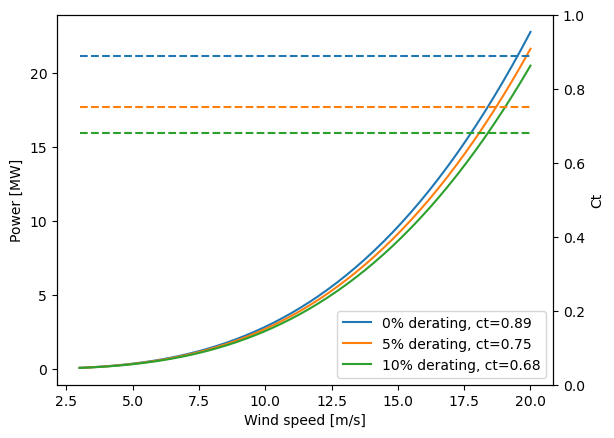

In [6]:
ax1 = plt.gca()
ax2 = plt.twinx(ax1)
ws = np.linspace(3, 20)
for derating in [0, .05, .1]:
    ct = wt.ct(ws, derating=derating)
    ax1.plot(ws, wt.power(ws, derating=derating) / 1e6, label='%d%% derating, ct=%.2f' % (derating * 100, ct[0]))
    ax2.plot(ws, ct,'--')

ax1.legend(loc='lower right')
ax1.set_xlabel('Wind speed [m/s]')
ax1.set_ylabel('Power [MW]')
ax2.set_ylabel('Ct')
ax2.set_ylim([0, 1])

#### Maximize mean power by optimizing de-rating factor and hub height

In this example we will maximize the mean power by optimizing the individual wind turbine hub height and derating factors.

First we setup the `WindFarmModel` and the function to maximize, `mean_power`, which takes the hub height and derating factors as input:

In [11]:
from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
from py_wake.site import UniformSite
from py_wake.utils.gradients import autograd

from topfarm._topfarm import TopFarmProblem
from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.easy_drivers import EasyScipyOptimizeDriver

n_wt = 5
wfm = IEA37SimpleBastankhahGaussian(site=UniformSite(p_wd=[1],ti=.1), windTurbines=wt)
wt_x = np.arange(n_wt) * 4 * wt.diameter()
wt_y = np.zeros_like(wt_x)

def mean_power(zhub, derating):
    power_ilk = wfm(x=wt_x, y=wt_y, h=zhub, wd=[270], ws=[10], derating=derating, return_simulationResult=False)[2] 
    return np.mean(power_ilk)

Setup the gradient function with respect to both arguments. 

Again the PyWake autograd method will, under the hood, calculate the gradients with respect to both inputs in one go.

In [12]:
dmean_power_dzhub_derating = autograd(mean_power,argnum=[0,1])

Initialize zhub and derating. The values are choosen to avoid zero gradients (e.g. if all wt has same hub height)

In [13]:
zhub = np.arange(n_wt)+100 # 100,101,102,...
derating=[0.1]*n_wt

In [14]:
print ('Mean power: %f MW'%(mean_power(zhub,derating)/1e6))
print ('Gradients:',dmean_power_dzhub_derating(zhub,derating))

Mean power: 1.429855 MW
Gradients: [array([-132.37798792,  -20.72030943,    9.44975613,   41.70595145,
        101.94258977]), array([   5539.55413631,  170225.9858809 ,  132322.76792935,
         39204.83341772, -234801.3362418 ])]


Next step is to setup the `CostModelComponent` and `TopFarmProblem`

In [15]:
cost_comp=CostModelComponent(input_keys=['zhub', 'derating'],
                              n_wt=n_wt,
                              cost_function=mean_power,
                              cost_gradient_function=dmean_power_dzhub_derating,
                              maximize=True # because we want to maximize the mean power
                             )

tf = TopFarmProblem(design_vars={
                        # (initial_values, lower limit, upper limit)
                        'zhub': ([100]*n_wt, 80, 130),
                        'derating': ([0] * n_wt, 0, .9)},  
                    n_wt=n_wt,
                    cost_comp=cost_comp,
                    expected_cost=1000, # expected cost impacts the size of the moves performed by the optimizer
                    )

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


As seen above the gradient of the mean power wrt. hub height is zero when all wind turbines have the same height. This means that the optimizer "thinks" that the solution cannot be improved. We therefore need to initialize the optimization with slightly different hub heights.

Furthermore, the derating must be above zero to avoid inequality constraint failure.

In [16]:
#perform the optimization
cost, state, recorder = tf.optimize(state={'zhub':np.arange(n_wt)+100,   # 100,101,102,...
                                           'derating':[0.1]*n_wt         # 10% initial derating
                                          })
print ()
print ('Optimized mean power %f MW'% (cost/1e6))
print ('Optimized state', state)

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1716.1873043790367
            Iterations: 38
            Function evaluations: 56
            Gradient evaluations: 36
Optimization Complete
-----------------------------------

Optimized mean power -1.716187 MW
Optimized state {'zhub': array([ 80., 130.,  80.,  80., 130.]), 'derating': array([0.08691683, 0.06260834, 0.19990203, 0.04530914, 0.        ])}


**Plotting the results**

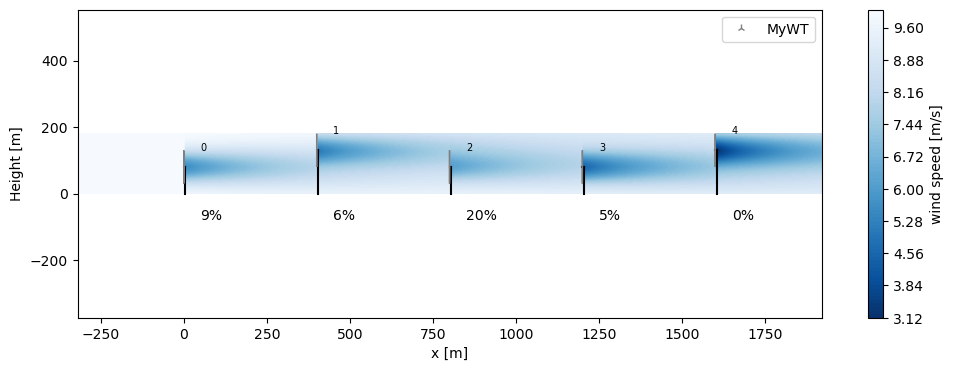

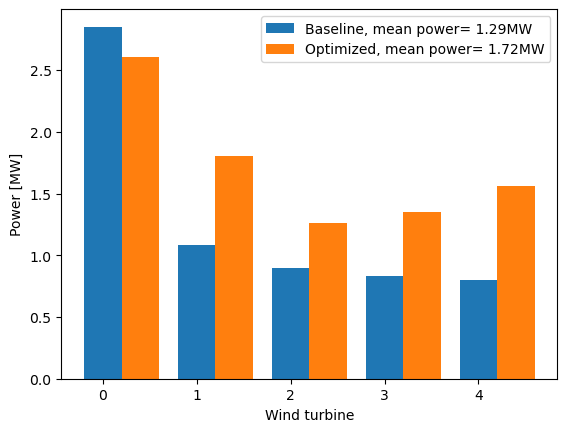

In [17]:
from py_wake import XZGrid
derating = state['derating']
h = state['zhub']

sim_res_ref = wfm(wt_x, wt_y, wd=[270], ws=[10], derating=[0] * n_wt)
sim_res_opt = wfm(wt_x, wt_y, h=h, wd=[270], ws=[10], derating=derating)
plt.figure(figsize=(12,4))
sim_res_opt.flow_map(XZGrid(y=0)).plot_wake_map()
for x_, d in zip(wt_x, derating):
    plt.text(x_ + 50, -80, "%d%%" % np.round(d * 100), fontsize=10)
plt.ylabel('Height [m]')
plt.xlabel('x [m]')

plt.figure()
for i, (sim_res, l) in enumerate([(sim_res_ref, 'Baseline'), (sim_res_opt, 'Optimized')]):
    plt.bar(np.arange(n_wt) + i * .4, sim_res.Power.squeeze() * 1e-6, width=.4,
            label='%s, mean power= %.2fMW' % (l, sim_res.Power.mean() * 1e-6))
plt.ylabel('Power [MW]')
plt.xlabel('Wind turbine')
plt.legend()
plt.show()